In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
df_descriptors = pd.read_csv("./data/standardized_AqSolDB_descriptors_imputed_2.csv")

In [3]:
# Extract features (X) and target (y)

X = df_descriptors.iloc[:, 5:]  # columns after first 5 are Mordred descriptors
y = df_descriptors['LogS']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (6674, 1536)
Target shape: (6674,)


In [4]:
# Keep only numerics
X = X.select_dtypes(include=[np.number])  
X = X.replace([np.inf, -np.inf], np.nan)

# Keep columns with at least 80% nonNaN values
X = X.dropna(axis=1, thresh=0.8 * len(X))  
X = X.fillna(X.mean())

print(f"Features after cleaning: {X.shape}")

Features after cleaning: (6674, 1536)


In [5]:
# Split train-test da
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)

print(f"Training set: {X_train.shape[0]} molecules")
print(f"Test set: {X_test.shape[0]} molecules")

Training set: 5339 molecules
Test set: 1335 molecules


In [6]:
# Scale the data
print("Scaling data...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Scaling data...


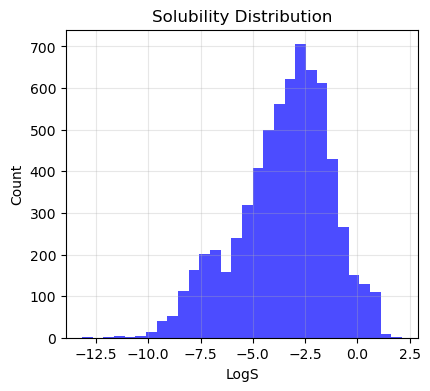

In [7]:
# Solubility distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(y, bins=30, alpha=0.7, color='blue')
plt.xlabel('LogS')
plt.ylabel('Count')
plt.title('Solubility Distribution')
plt.grid(True, alpha=0.3)

In [ ]:
# Train SVM model
print("Training SVM model...")

svm_model = SVR(kernel = 'rbf', C = 1.0, epsilon = 0.1 , gamma = 'scale') # Got good results with defaults

svm_model.fit(X_train_scaled, y_train)

print("SVM training completed!")

Training SVM model...
SVM training completed!


In [14]:
# Evaluate w/ epsilon 0.1 and C = 1.0
y_pred_test = svm_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(
    "SVM's Performance on Test Set:\n"
    f"  Mean Absolute Error:      {mae:.3f}\n"
    f"  R²:                       {r2:.3f}\n"
    f"  Root Mean Squared Error:  {rmse:.3f}"
)


SVM's Performance on Test Set:
  Mean Absolute Error:      0.648
  R²:                       0.813
  Root Mean Squared Error:  0.943


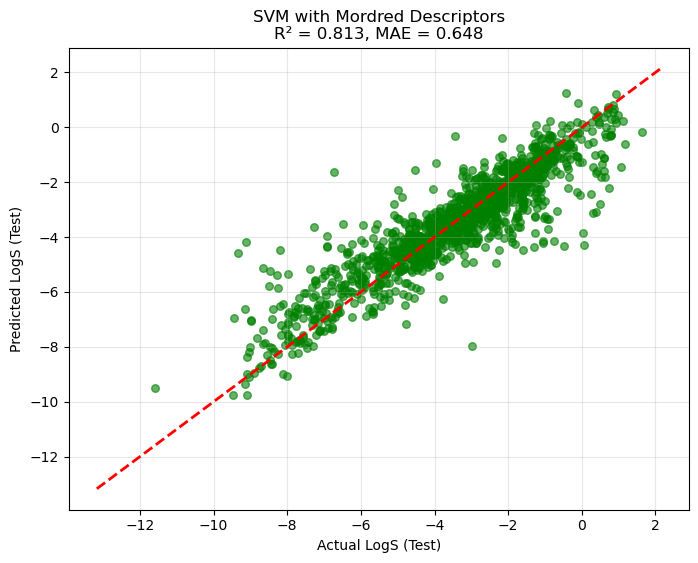

In [15]:
# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6, s=30, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel('Actual LogS (Test)')
plt.ylabel('Predicted LogS (Test)')
plt.title(f'SVM with Mordred Descriptors\nR² = {r2:.3f}, MAE = {mae:.3f}')
plt.grid(True, alpha=0.3)
plt.show()

In [16]:
# Save model
import joblib
model_data = {
    'model': svm_model,
    'scaler': scaler,
    'feature_names': X.columns.tolist()
}
joblib.dump(model_data, 'svm_solubility_model.pkl')
print("Model saved as 'svm_solubility_model.pkl'")

Model saved as 'svm_solubility_model.pkl'
